Columns: ['Contact: Card Number  ↑', 'Membership Type', 'Membership Status', 'Contact: Age', 'Contact: Data Warehouse: Racial/Ethnic Identity', 'Contact: Data Warehouse: Gender', 'Contact: Household Income Range', 'Contact: Household Composition', 'Contact: Zip Code']
  Contact: Card Number  ↑                        Membership Type  \
0                      21  Walworth School Year 24-25 Membership   
1                      22  Walworth School Year 24-25 Membership   
2                      23  Walworth School Year 24-25 Membership   
3                      24  Walworth School Year 24-25 Membership   
4                      25  Walworth School Year 24-25 Membership   

  Membership Status  Contact: Age  \
0          Complete          14.0   
1          Complete          13.0   
2          Complete          13.0   
3          Complete          11.0   
4          Complete          15.0   

  Contact: Data Warehouse: Racial/Ethnic Identity  \
0                       Black or African Ameri

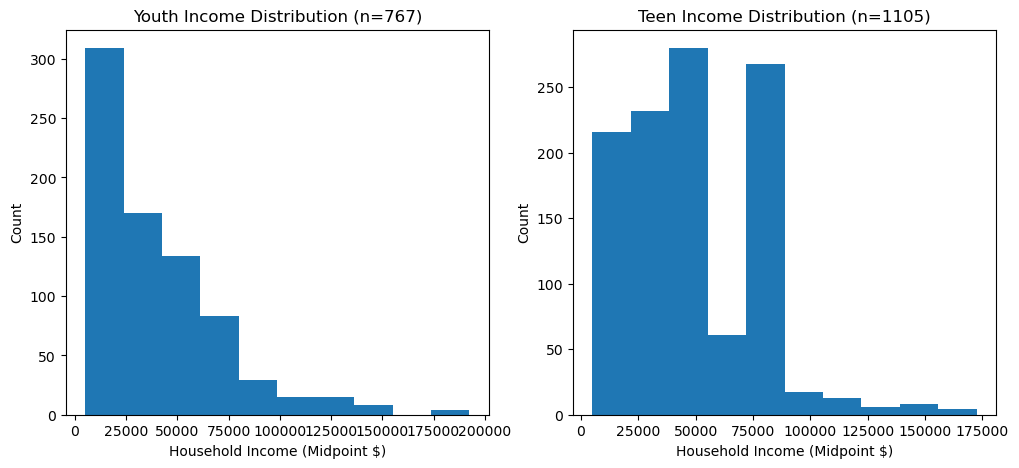

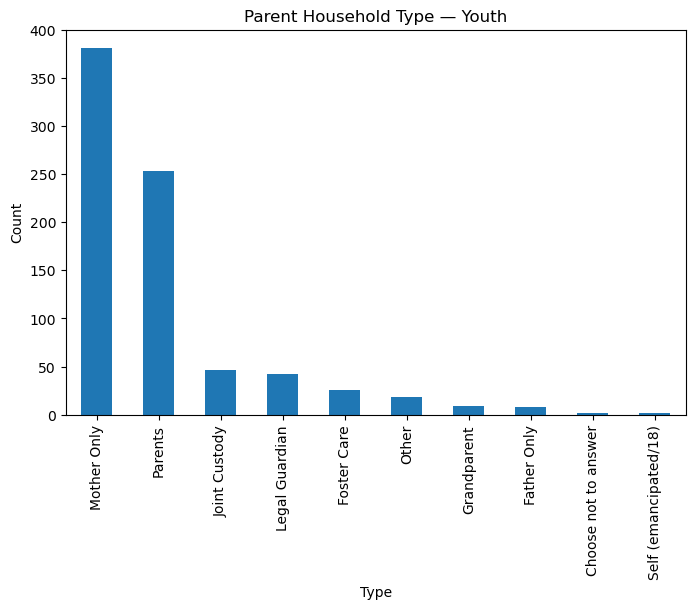

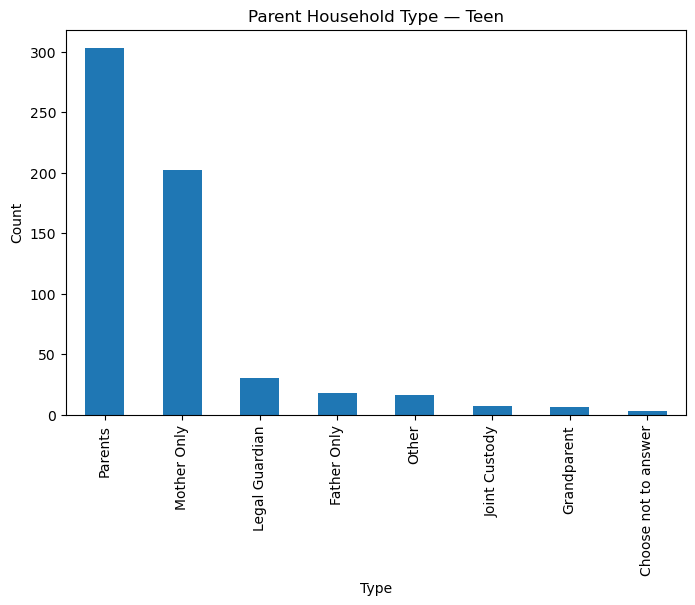

                                                 race  n_total  \
0                           Black or African American      843   
1                                               White      253   
2                            Hispanic or Latino;White       37   
3                    American Indian or Alaska Native       37   
4                                        Multi-Racial      189   
5                                  Hispanic or Latino      513   
6                        Bi-racial;Hispanic or Latino        2   
7                                           Bi-racial      114   
8                     Black or African American;White        8   
9        Black or African American;Hispanic or Latino        6   
10                    Middle Eastern or North African       13   
11             Black or African American;Multi-Racial        4   
12                             Bi-racial;Multi-Racial       16   
13                Bi-racial;Black or African American        9   
14        

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

df = pd.read_csv("Memberships.csv")

print("Columns:", df.columns.tolist())
print(df.head())

# Rename columns for easier use
df = df.rename(columns={
    'Contact: Age': 'age',
    'Contact: Data Warehouse: Racial/Ethnic Identity': 'race',
    'Contact: Household Income Range': 'income_range',
    'Contact: Household Composition': 'parent_household_type'
})

# Convert Age to numeric
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Assign Youth vs Teen Program Group
df['program_group'] = np.select(
    [
        df['age'].between(5, 12, inclusive='both'),
        df['age'].between(13, 18, inclusive='both')
    ],
    ['Youth', 'Teen'],
    default='Unknown'
)

# ----------------------------
# Convert income ranges into a numeric midpoint
# Example formats expected: "$20,000-$39,999"
# ----------------------------
def income_midpoint(r):
    if pd.isna(r):
        return np.nan
    # Remove $ and commas
    r = r.replace("$", "").replace(",", "")
    if "-" in r:
        low, high = r.split("-")
        return (float(low) + float(high)) / 2
    return np.nan  # if format unexpected

df['household_income'] = df['income_range'].apply(income_midpoint)

# ----------------------------
# Histogram of income by group (only numeric midpoints)
# ----------------------------
income_data = df[df['household_income'].notna() & df['program_group'].notna()]

groups = ['Youth', 'Teen']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, g in zip(axes, groups):
    sub = income_data[income_data['program_group'] == g]
    if not sub.empty:
        ax.hist(sub['household_income'], bins=10)
        ax.set_title(f"{g} Income Distribution (n={len(sub)})")
        ax.set_xlabel("Household Income (Midpoint $)")
        ax.set_ylabel("Count")
    else:
        ax.text(0.5, 0.5, f"No {g} data", ha='center')

plt.show()

# ----------------------------
# Bar charts: Parent household type by Youth vs Teen
# ----------------------------
for g in groups:
    sub = df[(df['program_group'] == g) & df['parent_household_type'].notna()]
    if not sub.empty:
        counts = sub['parent_household_type'].value_counts()
        plt.figure(figsize=(8, 5))
        counts.plot(kind='bar')
        plt.title(f"Parent Household Type — {g}")
        plt.xlabel("Type")
        plt.ylabel("Count")
        plt.show()

# ----------------------------
# Summary by race:
# avg income + most common parent household type
# ----------------------------
summary = []

for race in df['race'].dropna().unique():
    sub = df[df['race'] == race]
    
    # Mean income
    incomes = sub['household_income'].dropna()
    mean_inc = incomes.mean() if len(incomes) > 0 else np.nan
    
    # Most common parent household
    phts = sub['parent_household_type'].dropna()
    if len(phts) > 0:
        mc_pht = phts.value_counts().idxmax()
    else:
        mc_pht = np.nan
    
    summary.append({
        'race': race,
        'n_total': len(sub),
        'mean_household_income': mean_inc,
        'most_common_parent_household': mc_pht
    })

summary_df = pd.DataFrame(summary)
print(summary_df)
summary_df.to_csv("summary_by_race.csv", index=False)
